<a href="https://colab.research.google.com/github/AlexKressner/Business_Intelligence/blob/main/ML_Fallstudie_Online_Barber_Shop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study "Online Barber Shop"
Sie finden unter `./Daten/Barber/` den Ausschnitt eines Datensatzes einer **Direct-to-Consumer (D2C) Brand**, die über einen Onlineshop **Rasierer** und **Rasierzubehör** verkauft. Für das Unternehmen ist es enorm wichtig, dass es die voraussichtlichen **Absätze der nächsten 21 Tage** kennt, da es Waren im Voraus bei seinen Lieferanten bestellen muss. Je genauer die Absatzprognose, desto weniger Stockouts bzw. unnötige Bestände hat das Unternehmen und desto besser die Marge.

Bisher ist es dem Unternehmen nicht gelungen, gute Prognosen zu erstellen. Um dies zu ändern, werden Sie nun beauftragt, eine Prognose mithilfe von ML-Algorithmen anzufertigen. Dazu stellt Ihnen das Unternehmen einen ersten Datensatz aus seinem Shopsystem zur Verfügung. In diesem sind **3 Produkte** enthalten (Alaunstein, Bartbalm und ein Rasierer) und Sie sollen für diese jeweils eine Absatzprogonse erstellen. Bitte orientieren Sie sich bei der Bearbeitung der Fallstudie an der in diesem Notebook vorgeschlagenen Struktur und greifen Sie auf die Notebooks zurück, die wir bereits in der Vorlesung gemeinsam bearbeitet haben.

Die Struktur Ihres Notebooks sollte dabei wie folgt aussehen und u.a. die folgenden Fragen beantworten:

1. **Daten laden & aufbereiten**. Wichtig: Nachdem Sie die Daten geladen haben, müssen Sie diese zunächst auf Tage und je Produkt aggregieren.
2. **Datenexploration**, d.h. verschaffen Sie sich einen Überblick zum Datensatz. Sie sollten folgende Fragen beantworten:
  - Wie viele Absätze wurden über welchen Zeitraum je Produkt dokumentiert?
  - Was ist der Gesamtumsatz je Produkt?
  - Wie sind die Produktverkäufe im Zeitverlauf? Visualisieren Sie beispielweise die monatlichen/wöchentlichen Verkaufsmengen. Dies ist wichtig, um Trends oder Saisonalität in Zeitreihen zu erkennen.
  - Wie sind die durchschnittlichen Absätze pro Wochentag?
3. **Feature Engineering**
  - Entwickeln Sie basirend auf Ihrer Datenexploration nützliche Features für ein Vorhersagemodell.
  - Stellen Sie sich die Frage, mit welchen Features Sie Saisonalitäten abbilden können. Gibt es Monate in den die Absätze deutlich höher sind? Falls ja, sollten Sie ein Features einführen, das den Monat (Jan, Feb, ..., Dez) abbildet!
  - Bilden Sie autoregressive Features, z.B. könnte es Sinn ergeben zur Progonse des Absatzes an einem Tag (z.B. 15.03.) den Absatz des Vormonats zum gleichen Datum (15.02.) heranzuziehen.
  - Können Sie aus den zur Verfügung stehenden Daten den Stückpreis als Feature ableiten?
4. **Prognosemodell trainieren und bewerten**
  - Trainieren Sie ein globales Prognosemodell auf allen Daten und bewerten Sie dieses.
  - Trainieren Sie drei lokale Prognosemodelle (für Alaunstein, Bartbalm & Rasierer) und überprüfen Sie, ob die Prognosegüte verbessert wird.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'Daten\Barber\barber_shopify_data.csv', sep=';', parse_dates=['Datum'], decimal=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datum         1083 non-null   datetime64[ns]
 1   Produkt       1083 non-null   object        
 2   Nettomenge    1083 non-null   int64         
 3   Bruttoumsatz  1083 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 34.0+ KB


In [4]:
df.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz
0,2020-01-07,Alaunstein,0,0.00
1,2020-02-07,Alaunstein,0,0.00
2,2020-03-07,Alaunstein,0,0.00
3,2020-04-07,Alaunstein,0,0.00
4,2020-05-07,Alaunstein,1,8.39


In [5]:
df.head()

,Datum,Produkt,Nettomenge,Bruttoumsatz
0,2020-01-07,Alaunstein,0,0.00
1,2020-02-07,Alaunstein,0,0.00
2,2020-03-07,Alaunstein,0,0.00
3,2020-04-07,Alaunstein,0,0.00
4,2020-05-07,Alaunstein,1,8.39


In [6]:
df.columns = df.columns.str.replace('Versand Land', 'Versand_Land')

for col in df.columns:
    df.rename(columns={col: col.lower()}, inplace=True)
df.head()

,datum,produkt,nettomenge,bruttoumsatz
0,2020-01-07,Alaunstein,0,0.00
1,2020-02-07,Alaunstein,0,0.00
2,2020-03-07,Alaunstein,0,0.00
3,2020-04-07,Alaunstein,0,0.00
4,2020-05-07,Alaunstein,1,8.39


In [7]:
def preprocess_data(df):

    min_date = min(pd.to_datetime(df["datum"]))
    max_date = max(pd.to_datetime(df["datum"]))

    dates = (
        pd.date_range(start=min_date, end=max_date, name="datum")
        .to_frame()
        .reset_index(drop=True)
    )
    dates = (
        pd.merge(dates, df["produkt"], how="cross")
        .drop_duplicates()
        .reset_index(drop=True)
    )

    return pd.merge(dates, df, how="left", on=["datum", "produkt"]).fillna(0)


df_agg = df.copy().groupby(["datum", "produkt"]).agg({"nettomenge": "sum", "bruttoumsatz": "sum"}).reset_index()


In [8]:
def get_agg_for_col(df: pd.DataFrame, group_col: list[str] | str, agg_col: str, agg_func: str = 'sum', sorted: bool = False, ascending: bool = False) -> pd.DataFrame:
    if isinstance(group_col, str):
        group_col = [group_col]
    if agg_func == 'sum':
        agg_result = df.groupby(group_col)[agg_col].sum()
    elif agg_func == 'mean':
        agg_result = df.groupby(group_col)[agg_col].mean()
    elif agg_func == 'count':
        agg_result = df.groupby(group_col)[agg_col].count()
    elif agg_func == 'min':
        agg_result = df.groupby(group_col)[agg_col].min()
    elif agg_func == 'max':
        agg_result = df.groupby(group_col)[agg_col].max()
    else:
        raise ValueError(f"Invalid aggregation function: {agg_func}")
    
    agg_result = agg_result.reset_index()
    
    if sorted:
        agg_result = agg_result.sort_values(by=agg_col, ascending=ascending)
    
    return agg_result


In [9]:
df_agg.head()

,datum,produkt,nettomenge,bruttoumsatz
0,2020-01-07,Alaunstein,0,0.0
1,2020-01-08,Alaunstein,0,0.0
2,2020-01-09,Alaunstein,0,0.0
3,2020-01-10,Alaunstein,0,0.0
4,2020-01-11,Alaunstein,0,0.0


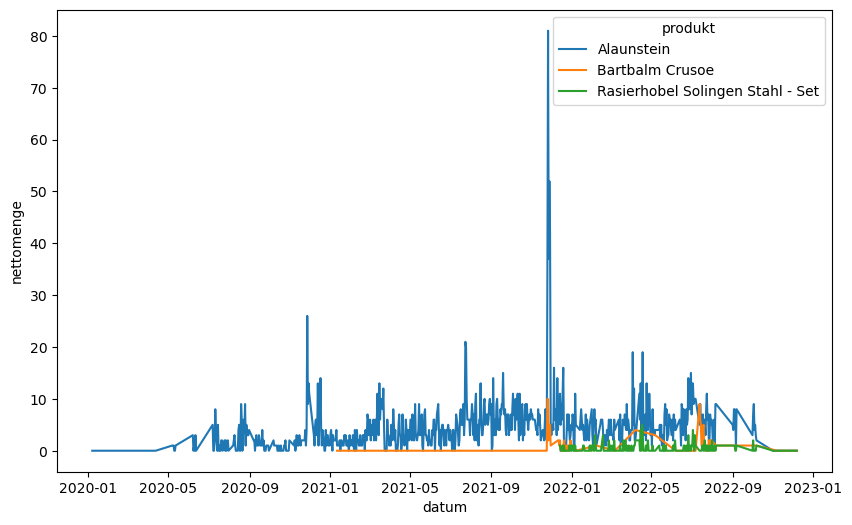

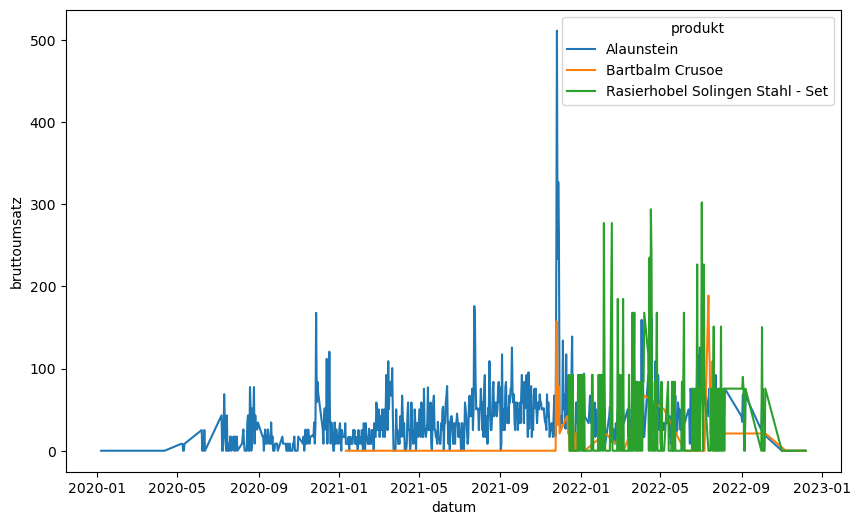

In [10]:
agg_cols = ['nettomenge', 'bruttoumsatz']
for col in agg_cols:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=get_agg_for_col(df, ['datum', 'produkt'], col ), x='datum', y=col, hue='produkt')
    plt.show()

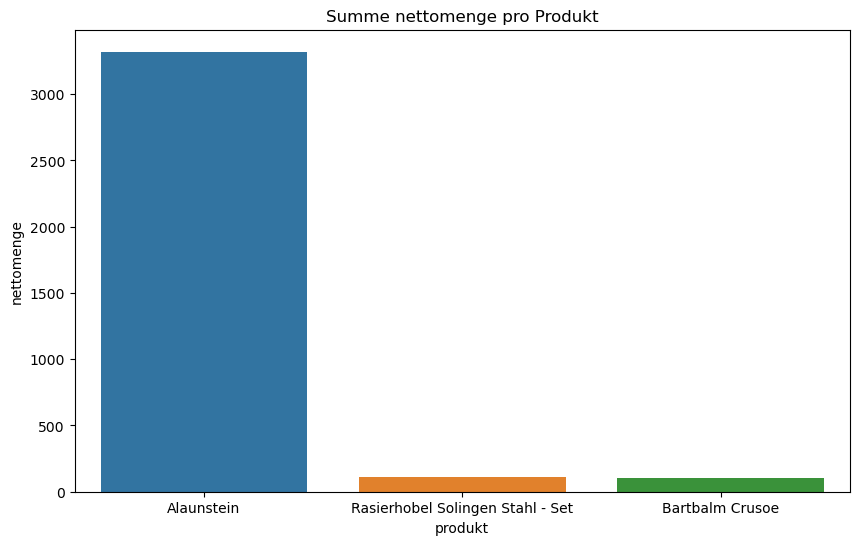

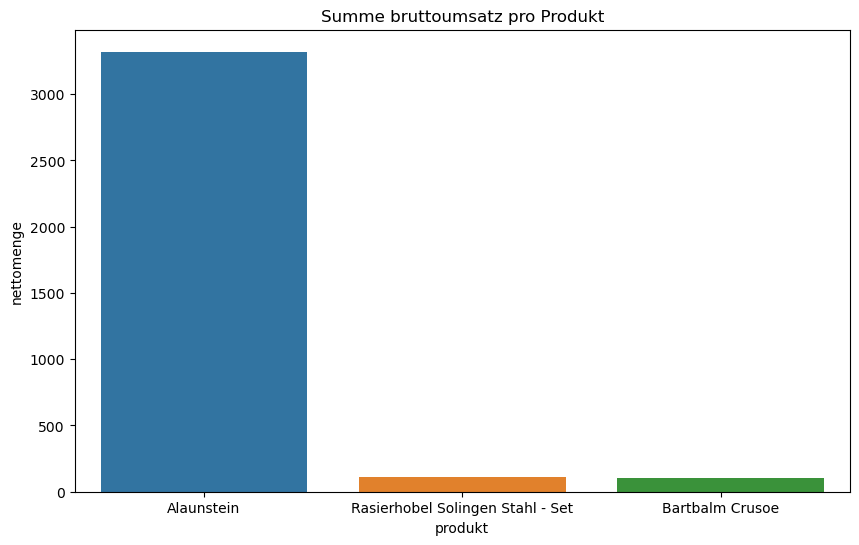

In [11]:
for col in ['nettomenge', 'bruttoumsatz']:
    plt.figure(figsize=(10, 6))
    plt.title(f'Summe {col} pro Produkt')
    sns.barplot(data=get_agg_for_col(df, 'produkt', 'nettomenge', sorted=True), x='produkt', y='nettomenge')
    plt.show()


In [12]:
def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    df['year'] = df['datum'].dt.year
    df['month'] = df['datum'].dt.month
    df['day'] = df['datum'].dt.day
    df['week'] = df['datum'].dt.isocalendar().week
    df['weekday'] = df['datum'].dt.weekday
    df['day_of_year'] = df['datum'].dt.dayofyear
    df['quarter'] = df['datum'].dt.quarter
    return df

In [13]:
df_agg.head()

,datum,produkt,nettomenge,bruttoumsatz
0,2020-01-07,Alaunstein,0,0.0
1,2020-01-08,Alaunstein,0,0.0
2,2020-01-09,Alaunstein,0,0.0
3,2020-01-10,Alaunstein,0,0.0
4,2020-01-11,Alaunstein,0,0.0


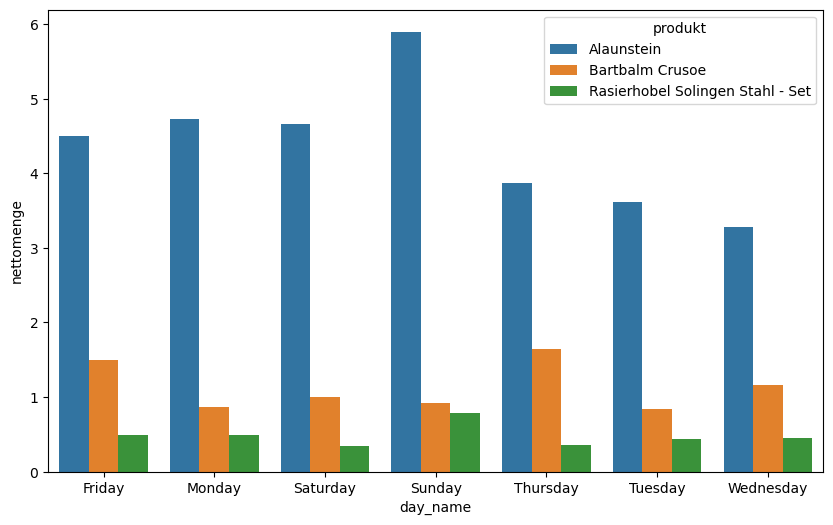

In [14]:
df_agg = add_datetime_features(df_agg)
df_agg['day_name'] = df_agg['datum'].dt.day_name()

plt.figure(figsize=(10, 6))
sns.barplot(data=get_agg_for_col(df_agg, ['day_name', 'produkt'], 'nettomenge', agg_func='mean'), x='day_name', y='nettomenge', hue='produkt')
plt.show()

In [15]:
df_agg.sort_values(by="datum", inplace=True, ascending=True)

df_agg["sales_lag1d"] = df_agg.groupby("produkt")["nettomenge"].transform(
    lambda x: x.shift(21)
)
df_agg["3d_rolling_demand"] = df_agg.groupby("produkt")["nettomenge"].transform(
    lambda x: x.shift(21).rolling(window=3).mean()
)
df_agg.tail(10)

,datum,produkt,nettomenge,bruttoumsatz,year,month,day,week,weekday,day_of_year,quarter,day_name,sales_lag1d,3d_rolling_demand
1073,2022-12-03,Rasierhobel Solingen Stahl - Set,0,0.0,2022,12,3,48,5,337,4,Saturday,1.0,1.000000
1074,2022-12-04,Alaunstein,0,0.0,2022,12,4,48,6,338,4,Sunday,8.0,6.666667
1075,2022-12-04,Rasierhobel Solingen Stahl - Set,0,0.0,2022,12,4,48,6,338,4,Sunday,1.0,1.000000
1076,2022-12-05,Alaunstein,0,0.0,2022,12,5,49,0,339,4,Monday,6.0,7.333333
1077,2022-12-05,Rasierhobel Solingen Stahl - Set,0,0.0,2022,12,5,49,0,339,4,Monday,0.0,0.666667
1078,2022-12-06,Alaunstein,0,0.0,2022,12,6,49,1,340,4,Tuesday,1.0,5.000000
1079,2022-12-06,Rasierhobel Solingen Stahl - Set,0,0.0,2022,12,6,49,1,340,4,Tuesday,0.0,0.333333
1081,2022-12-07,Bartbalm Crusoe,0,0.0,2022,12,7,49,2,341,4,Wednesday,5.0,6.666667
1080,2022-12-07,Alaunstein,0,0.0,2022,12,7,49,2,341,4,Wednesday,8.0,5.000000
1082,2022-12-07,Rasierhobel Solingen Stahl - Set,0,0.0,2022,12,7,49,2,341,4,Wednesday,1.0,0.333333


In [16]:
def create_rolling_transform(df: pd.DataFrame, groupby_cols: list[str], column: str, shift_val: int, window_size: int) -> pd.DataFrame:
    df[column + f"_lag{shift_val}d"] = df.groupby(groupby_cols)[column].transform(lambda x: x.shift(shift_val))
    df[column + f"_{window_size}d_rolling_demand"] = df.groupby(groupby_cols)[column].transform(lambda x: x.shift(shift_val).rolling(window=window_size).mean())
    return df

In [17]:
df_agg["item_value"] = df_agg["bruttoumsatz"] / df_agg["nettomenge"]
df_agg.dropna(inplace=True)
df_agg.drop(columns="day_name", inplace=True)

In [18]:
df_agg.set_index("datum", inplace=True)

## Model global

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from xgboost import XGBRegressor


# preprocessing functions
def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:

    df["year"] = df["datum"].dt.year

    df["month"] = df["datum"].dt.month

    df["day"] = df["datum"].dt.day

    df["week"] = df["datum"].dt.isocalendar().week.astype(int)

    df["weekday"] = df["datum"].dt.weekday

    df["day_of_year"] = df["datum"].dt.dayofyear

    df["quarter"] = df["datum"].dt.quarter
    return df


def create_rolling_transform(
    df: pd.DataFrame,
    groupby_cols: list[str],
    column: str,
    shift_val: int,
    window_size: int,
) -> pd.DataFrame:
    df.sort_values(by="datum", inplace=True, ascending=True)
    df[f"{column}_lag{shift_val}d"] = df.groupby(groupby_cols)[column].transform(
        lambda x: x.shift(shift_val)
    )

    df[f"{column}_{window_size}d_rolling"] = df.groupby(groupby_cols)[column].transform(
        lambda x: x.shift(shift_val).rolling(window=window_size).mean()
    )
    return df


def calc_avg_item_value(df: pd.DataFrame) -> pd.DataFrame:
    df["item_value"] = df["bruttoumsatz"] / df["nettomenge"]
    return df


# load data
df = pd.read_csv(
    r"Daten\Barber\barber_shopify_data.csv", sep=";", parse_dates=["Datum"], decimal=","
)


df.columns = df.columns.str.replace("Versand Land", "Versand_Land")
for col in df.columns:
    df.rename(columns={col: col.lower()}, inplace=True)

# preprocess data
df_agg = (
    df.copy()
    .groupby(["datum", "produkt"])
    .agg({"nettomenge": "sum", "bruttoumsatz": "sum"})
    .reset_index()
)

# preprocess_data(df_agg)
add_datetime_features(df_agg)
calc_avg_item_value(df_agg)

df_agg.head()

,datum,produkt,nettomenge,bruttoumsatz,year,month,day,week,weekday,day_of_year,quarter,item_value
0,2020-01-07,Alaunstein,0,0.0,2020,1,7,2,1,7,1,NaN
1,2020-01-08,Alaunstein,0,0.0,2020,1,8,2,2,8,1,NaN
2,2020-01-09,Alaunstein,0,0.0,2020,1,9,2,3,9,1,NaN
3,2020-01-10,Alaunstein,0,0.0,2020,1,10,2,4,10,1,NaN
4,2020-01-11,Alaunstein,0,0.0,2020,1,11,2,5,11,1,NaN


In [20]:

rolling_kwargs = {
    "n_30_3": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 3,
    },
    "n_30_7": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 7,
    },
    "n_30_30": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 30,
    },
    "n_30_90": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 90,
    },
    "n_30_180": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 180,
    },
    "n_30_365": {
        "groupby_cols": ["produkt"],
        "column": "nettomenge",
        "shift_val": 30,
        "window_size": 365,
    },
}


for key, value in rolling_kwargs.items():
    create_rolling_transform(df_agg, **value)

df_agg.set_index("datum", inplace=True)
df_agg.drop(columns="bruttoumsatz", inplace=True)


# create holdout set last 30 days
holdout_split = '2022-06-01'
df_agg = df_agg[df_agg.index < '2022-07-01']
holdout_data = df_agg[df_agg.index >= holdout_split]
df_agg_train_test = df_agg[df_agg.index < holdout_split]
df_agg.head()

,produkt,nettomenge,year,month,day,week,weekday,day_of_year,quarter,item_value,nettomenge_lag30d,nettomenge_3d_rolling,nettomenge_7d_rolling,nettomenge_30d_rolling,nettomenge_90d_rolling,nettomenge_180d_rolling,nettomenge_365d_rolling
datum,,,,,,,,,,,,,,,,,
2020-01-07,Alaunstein,0,2020,1,7,2,1,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,Alaunstein,0,2020,1,8,2,2,8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,Alaunstein,0,2020,1,9,2,3,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,Alaunstein,0,2020,1,10,2,4,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,Alaunstein,0,2020,1,11,2,5,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
models = {}
for product in df_agg_train_test["produkt"].unique():
    df_global_train_test = df_agg_train_test[df_agg_train_test["produkt"] == product].drop(columns='produkt').copy()
    


    # Split the dataset into training and testing sets
    train_size = int(len(df_global_train_test) * 0.8)
    train_data = df_global_train_test[:train_size]
    test_data = df_global_train_test[train_size:]

    # Prepare the features and target variables
    X_train = train_data.drop(columns=["nettomenge"])
    y_train = train_data["nettomenge"]
    X_test = test_data.drop(columns=["nettomenge"])
    y_test = test_data["nettomenge"]
    
    # Create an instance of the model
    model = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.1, n_jobs=-1, objective='reg:squarederror', early_stopping_rounds=50)


    # Fit the model to the training data
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
    models[product] = model


[0]	validation_0-rmse:6.33874	validation_1-rmse:5.01725
[1]	validation_0-rmse:5.88340	validation_1-rmse:4.77121
[2]	validation_0-rmse:5.46414	validation_1-rmse:4.51077
[3]	validation_0-rmse:5.08869	validation_1-rmse:4.27203
[4]	validation_0-rmse:4.75911	validation_1-rmse:4.09930
[5]	validation_0-rmse:4.45728	validation_1-rmse:3.94646
[6]	validation_0-rmse:4.18501	validation_1-rmse:3.80887
[7]	validation_0-rmse:3.93997	validation_1-rmse:3.69419
[8]	validation_0-rmse:3.72531	validation_1-rmse:3.54861
[9]	validation_0-rmse:3.52453	validation_1-rmse:3.47680
[10]	validation_0-rmse:3.34472	validation_1-rmse:3.37535
[11]	validation_0-rmse:3.18189	validation_1-rmse:3.26845
[12]	validation_0-rmse:3.03271	validation_1-rmse:3.19125
[13]	validation_0-rmse:2.89525	validation_1-rmse:3.11702
[14]	validation_0-rmse:2.76067	validation_1-rmse:3.06535
[15]	validation_0-rmse:2.64553	validation_1-rmse:3.00543
[16]	validation_0-rmse:2.53851	validation_1-rmse:2.95598
[17]	validation_0-rmse:2.43511	validation

In [22]:
forecast_df = pd.DataFrame()
for product in models:
    model = models[product]
    
    holdout_data_product = holdout_data[holdout_data['produkt'] == product].drop(columns='produkt').copy()
    X_holdout = holdout_data_product.drop(columns=["nettomenge"])
    y_holdout = holdout_data_product["nettomenge"].reset_index()

    # Predict the target variable for the testing data
    y_forecast_new = model.predict(X_holdout)
    y_forecast_new = pd.DataFrame(y_forecast_new, index=y_holdout['datum'], columns=["forecast"]).reset_index()
    y_forecast_new["produkt"] = product
    forecast_df_temp= pd.merge(y_holdout, y_forecast_new, how='inner', on='datum')
    forecast_df = pd.concat([forecast_df, forecast_df_temp] , axis=0)


In [23]:
mse = mean_squared_error(y_holdout["nettomenge"], y_forecast_new["forecast"])
mae = mean_absolute_error(y_holdout["nettomenge"], y_forecast_new["forecast"])
mape = mean_absolute_percentage_error(y_holdout["nettomenge"], y_forecast_new["forecast"])



print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.15223629199767075
Mean Absolute Error: 0.22934745788574218
Mean Absolute Percentage Error: 273364059821179.0


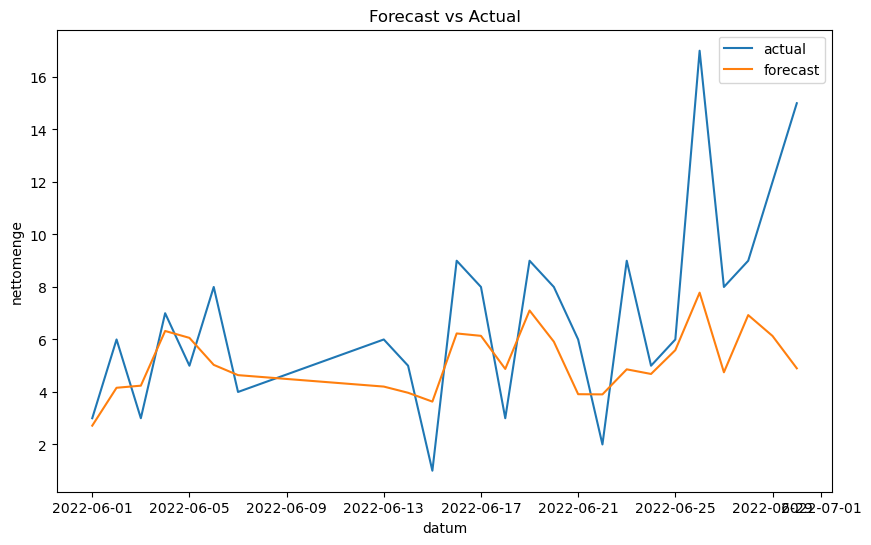

In [24]:
# Plot the forecast
forecast_df_total = forecast_df.groupby(['datum']).agg({'nettomenge': 'sum', 'forecast': 'sum'}).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=forecast_df_total, x='datum', y='nettomenge', label='actual')
sns.lineplot(data=forecast_df_total, x='datum', y='forecast', label='forecast')
plt.title('Forecast vs Actual')
plt.show()


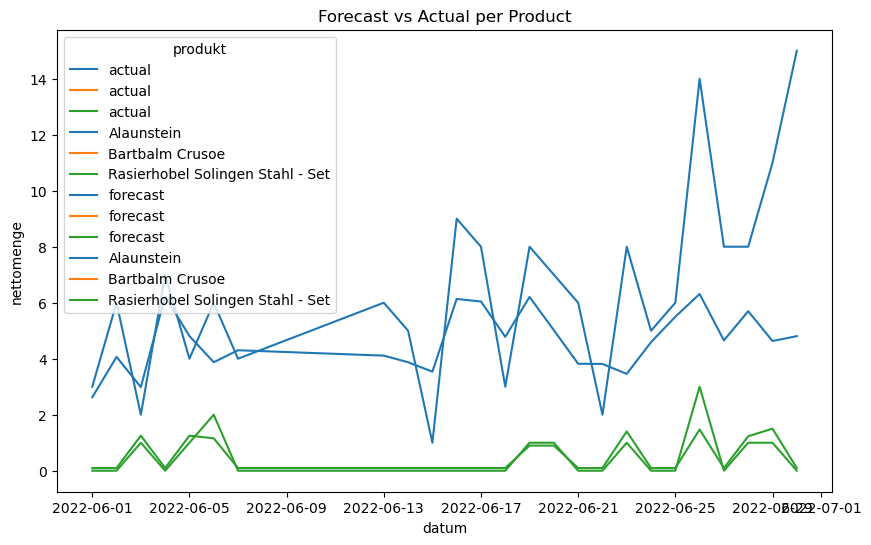

In [25]:
# Plot the forecast per product
plt.figure(figsize=(10, 6))
sns.lineplot(data=forecast_df, x='datum', y='nettomenge', hue='produkt', label='actual')
sns.lineplot(data=forecast_df, x='datum', y='forecast', hue='produkt', label='forecast')
plt.title('Forecast vs Actual per Product')
plt.show()